# Digital Watermarking for Data Security

#### BY AVI KHANDELWAL, 204102301

### Importing packages -

In [ ]:
from numpy import sin,cos,pi,sqrt
import numpy as np
import matplotlib.pyplot as plt
import math as m
import warnings
import cmath
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import cv2 
from google.colab import files
from skimage import io
from skimage.util import random_noise
from scipy.io import loadmat
from google.colab import drive
from google.colab.patches import cv2_imshow
from numpy import linalg as la
from copy import deepcopy

from PIL import Image, ImageFilter 

warnings.filterwarnings('ignore')

import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

### 0. Function definitions - 

In [ ]:
# DCT Function definition for 8*8 block of image

def dctTransform(matrix):

  dct = np.zeros((8,8))
  
  for i in range(8):
    for j in range(8):

      if (i == 0):
        ci = 1 / sqrt(2)
      else:
        ci = 1

      if (j == 0):
        cj = 1 / sqrt(2)
      else:
        cj = 1

      sum = 0

      for x in range(8):
        for y in range(8):
          dct1 = matrix[x][y] * cos(((2*x + 1)* i * pi) / 16) * cos(((2*y + 1) * j * pi) / 16)
          sum = sum + dct1
      
      dct[i][j] = (1/4) * ci * cj * sum

  return dct

# IDCT Function definition for 8*8 block of data
def idctTransform(matrix):

  idct = np.zeros([8,8])
  
  for x in range(8):
    for y in range(8):
      
      sum = 0
      
      for u in range(8):
        for v in range(8):
          if (u == 0):
            cu = 1 / sqrt(2)
          else:
            cu = 1

          if (v == 0):
            cv = 1 / sqrt(2)
          else:
            cv = 1

          dct1 = cu * cv * matrix[u][v] * cos(((2*x + 1)* u * pi) / 16) * cos(((2*y + 1) * v * pi) / 16)
          sum = sum + dct1
      
      idct[x][y] = (1/4) * sum

  return idct

## PART A: Watermark Embedding Algorithm 

### 1. Visualising the input image

In [ ]:
def input_visual(image):
  #drive.mount('/content/drive') # Mounting google drive
  img1 = cv2.imread('/content/drive/My Drive/files/'+image) # Reading image
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Adjusting color channels
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # changing the color channel from RGB to gray 
  return img1

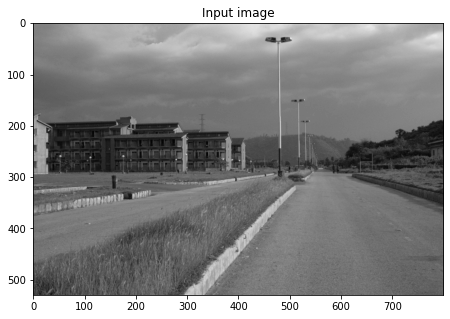

In [ ]:
img1 = input_visual("IITG.jpg")
plt.figure(1,figsize=(10,5))
plt.title("Input image")
plt.imshow(img1,cmap="gray")

### 2. Image preprocessing

In [ ]:
def img_preprocess(img1):

  m,n = img1.shape # To calculate the number of row and column pixels
  print("Image size before rounding:",img1.shape)
  m = m//8
  n = n//8
  # Since we will be passing data as 8*8 block in DCT function, 
  # hence rounding the number of row and column pixels to nearest multiple of 8
  img = img1[:8*m,:8*n]
  print("Image size after rounding:",img.shape)
  return img

In [ ]:
img = img_preprocess(img1)

Image size before rounding: (530, 800)
Image size after rounding: (528, 800)


### 3. Discrete Cosine Transform operation

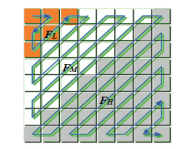

In [ ]:
def dct_image(img,img1):

  m,n = img1.shape 
  m = m//8
  n = n//8

  img_dct = np.zeros((8*m,8*n)) # Initialing an empty 2D DCT array to store DCT values

  # Initialising an empty 2D array, X to store the low frequency DCT coefficients of all DCT computed blocks in 
  # the given image, since DCT essentially performs 'energy compaction' hence out of low, middle and high frequency bands, only low
  # frequency bands coefficients will be containing necessary information whearas middle and high frequency DCT coefficients 
  # will be almost zero, hence ignoring them in further calculation.

  X = np.zeros((m*n,6)) 

  count = 0 # To keep track of number of iterations

  for i in range(0,8*m,8):
    for j in range(0,8*n,8):

      # Initialising vector to store the low frequency coefficients of DCT block
      x = np.zeros(6) 

      img_dct[i:i+8,j:j+8] = dctTransform(img[i:i+8,j:j+8]) # DCT transformation operation on 8*8 block

      # storing the low frequency coefficients of DCT block in x
      x[0] = img_dct[i:i+8,j:j+8][0][0]
      x[1] = img_dct[i:i+8,j:j+8][0][1]
      x[2] = img_dct[i:i+8,j:j+8][1][0]
      x[3] = img_dct[i:i+8,j:j+8][2][0]
      x[4] = img_dct[i:i+8,j:j+8][1][1]
      x[5] = img_dct[i:i+8,j:j+8][0][2]
      X[count,:] = x 
      count += 1
  
  print("Dimensions of X are:",X.shape,"\n")
  print("X.head",end="\n\n")
  print(X[:5,:])
  return X,img_dct

In [ ]:
X,img_dct = dct_image(img,img1)

Dimensions of X are: (6600, 6) 

X.head

[[ 1.02362500e+03  3.13507290e+00  8.38528695e+00  1.89219493e+00
   7.84780026e-01 -1.63320371e-01]
 [ 1.02162500e+03 -1.89863255e+00  1.54512122e+01  1.75689591e+00
  -2.33603353e-01  1.04757174e+00]
 [ 1.02150000e+03  4.44230089e-02  1.03989819e+01  2.30969883e+00
  -8.14185361e-01 -5.97238791e-01]
 [ 1.02687500e+03 -2.66988592e+00  1.05235893e+01  1.85256677e+00
   9.84203375e-01  5.62418327e-01]
 [ 1.05025000e+03 -7.79058081e+00  1.09450620e+01  1.80813090e+00
  -1.65754748e+00 -9.63507699e-01]]


### 4. Principal Component Analysis - for reducing correlation between the 6 dimensions 

In [ ]:
def PCA_img(X):

  mu = 0 # Initialising mean
  sum = 0 
  cov = 0 # Initialising covariance matrix

  # Mean calculation, where x is 6*1 column vector in X containing 6600 such column vectors
  for x in X:
    sum += x
  mu = sum/len(X) 
  print("Mean of the feature vectors:")
  print(mu)
  print("\n")
  print("shape of mean:",mu.shape)
  print("\n")

  # Covariance matrix calculation
  for x in X:
    cov += np.outer((x-mu),np.transpose(x-mu))
  cov = cov/len(X)
  print("Covariance matrix of the feature vectors:")
  print(cov)
  print("\n")
  print("shape of Covariance matrix:",cov.shape)
  print("\n")

  # Eigen values and eigen vectors of the covariance matrix 
  val, A = la.eig(cov)
  print("Eigen vector matrix, A:")
  print(A)
  print("\n")
  print("shape of A:",A.shape)
  print("\n")

  # Calculating matrix Y, having data non-correlated in all 6 dimensions
  Y = np.matmul(A,np.transpose(X))
  print("Principal component space, Y:")
  print(Y)
  print("\n")
  print("shape of Y matrix:",Y.shape)

  return A,Y

In [ ]:
A,Y = PCA_img(X)

Mean of the feature vectors:
[9.19407481e+02 9.38933252e-01 1.95894530e+00 3.94532219e-01
 1.09061250e-01 1.68267932e-01]


shape of mean: (6,)


Covariance matrix of the feature vectors:
[[ 6.35872461e+04  1.17500885e+01  7.83070314e+02 -5.60435118e+02
  -1.89316471e+02 -2.13016409e+02]
 [ 1.17500885e+01  1.07945780e+03  1.83743907e+02 -1.01653303e+01
  -2.36951846e+01  2.12922603e+00]
 [ 7.83070314e+02  1.83743907e+02  1.69334720e+03 -5.84802994e+01
   7.14305703e+00 -1.78680863e+01]
 [-5.60435118e+02 -1.01653303e+01 -5.84802994e+01  4.62620120e+02
   3.25592851e+01  1.70731943e+01]
 [-1.89316471e+02 -2.36951846e+01  7.14305703e+00  3.25592851e+01
   2.63323302e+02  1.47559553e+01]
 [-2.13016409e+02  2.12922603e+00 -1.78680863e+01  1.70731943e+01
   1.47559553e+01  4.71571745e+02]]


shape of Covariance matrix: (6, 6)


Eigen vector matrix, A:
[[-9.99870173e-01  1.26390559e-02  3.17233119e-03  1.63315307e-03
  -5.14556114e-03  7.78999525e-03]
 [-2.27563933e-04 -2.69114685e-01  9.6256

### 5. Logo to be watermarked

In [ ]:
def load_logo(img1):

  m,n = img1.shape 
  m = m//8
  n = n//8
  count = m*n

  logo1 = cv2.imread('/content/drive/My Drive/files/IITG_White.png') # Reading logo
  logo1 = cv2.cvtColor(logo1, cv2.COLOR_BGR2GRAY) # Adjusting color channels

  logo1 = np.where(logo1>128, 1, 0) # convering the 2D array, logo1 into a binary array 

  # Appending zeros at the end of logo array
  logo = logo1.flatten()
  logo = np.concatenate([logo,np.zeros(count-logo.size)])

  return logo,logo1

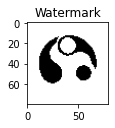

In [ ]:
logo,logo1 = load_logo(img1)
plt.figure(1,figsize=(1.5,1.5))
plt.title("Watermark")
plt.imshow(logo1,cmap="gray")

### 6. Embedding watermark into the image

In [ ]:
def embed(Y,A,logo,img1,img_dct,alpha=30):
  
  # alpha is a value chosen on compromise between robustness and invisibility of watermarking

  Y_embed = deepcopy(Y) # Creating a new array to store the embedded watermarked image

  m,n = img1.shape 
  m = m//8
  n = n//8
  count = m*n

  for i in range(count):
    Y_embed[0][i] += alpha*logo[i] # embedding the watermark

  # Inverse PCA operation
  X_embed = np.matmul(la.inv(A),Y_embed)
  X_embed = X_embed.transpose() 

  img_wm = np.zeros((8*m,8*n)) # Initialising an empty 2D  array to store watermarked image

  itr = 0 # To keep track of number of iterations

  for i in range(0,8*m,8):
    for j in range(0,8*n,8):

      # Vector to store the 6 low frequencies coefficients
      x = X_embed[itr]

      # storing the low frequency coefficients of DCT block in x
      img_dct[i:i+8,j:j+8][0][0] = x[0]
      img_dct[i:i+8,j:j+8][0][1] = x[1]
      img_dct[i:i+8,j:j+8][1][0] = x[2]
      img_dct[i:i+8,j:j+8][2][0] = x[3]
      img_dct[i:i+8,j:j+8][1][1] = x[4]
      img_dct[i:i+8,j:j+8][0][2] = x[5]
      itr += 1

      # IDCT operation
      img_wm[i:i+8,j:j+8] = idctTransform(img_dct[i:i+8,j:j+8]) # IDCT transformation operation on 8*8 block

  return img_wm

In [ ]:
img_wm = embed(Y,A,logo,img1,img_dct)

### 7. Original image and Watermarked image 

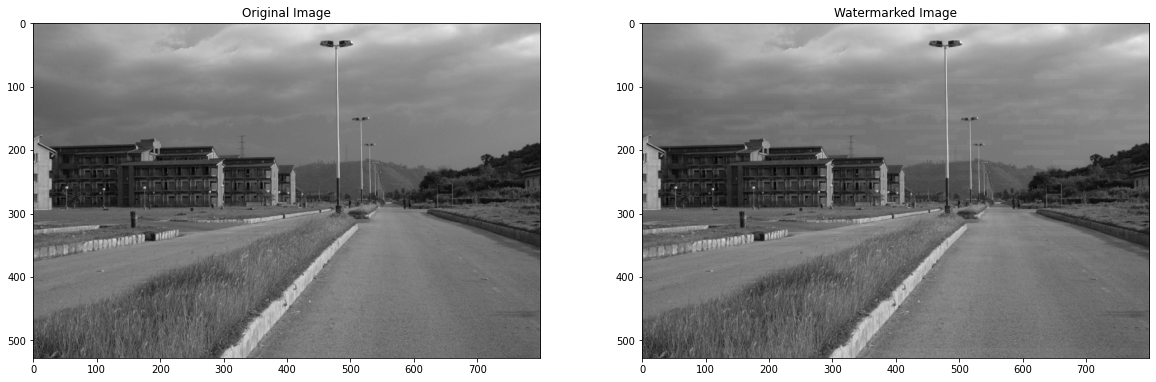

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Image", fontsize='large')
ax1.imshow(img,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image", fontsize='large')
ax2.imshow(img_wm,cmap = "gray")

## PART B. Watermark Detection Algorithm

In [ ]:
def detect(img,img_wm,img1,logo1,alpha=30):
  
  m,n = img1.shape 
  m = m//8
  n = n//8
  count = m*n

  row,col = logo1.shape 

  with HiddenPrints():
    X,img_dct = dct_image(img,img1)
    Xw,img_wm_dct = dct_image(img_wm,img1)

    # PCA is applied to the DCT matrix data
    A,Y = PCA_img(X)
    Aw,Yw = PCA_img(Xw)

    # The watermark bits are extracted from the first component of the PCA
    w = np.zeros(count)

    for i in range(count):
      w[i] = (Yw[0,i] - Y[0,i])/alpha

    w = w[:row*col]
    w = w.reshape(row,col)
    return w

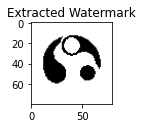

In [ ]:
w = detect(img,img_wm,img1,logo1,alpha=30)
plt.figure(figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w,cmap="gray")

### PART C. EVALUATION CRITERIA

### 1. Peak Signal to Noise Ratio (PSNR)

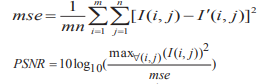

##### Peak Signal to Noise Ratio (PSNR) is a criteria for evaluation of the image quality after the watermarking. Invisibility of a watermarking scheme can be described by PSNR. It is targeted to 40 dB

In [ ]:
def PSNR(img,img_wm,img1):
  m,n = img1.shape 
  m = m//8
  n = n//8
  sum = 0
  for i in range(8*m):
    for j in range(8*n):
      sum += pow((img[i,j] - img_wm[i,j]),2)
  mse = sum/(8*m*8*n)
  psnr = 10*np.log10((pow(np.max(img),2))/mse)
  print("PSNR(dB):",psnr)

In [ ]:
PSNR(img,img_wm,img1)

PSNR(dB): 36.87937713320518


### 2. Normalized Correlation (NC)

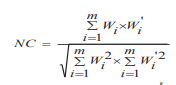

##### Normalized Correlation (NC) is used for comparison between the original watermark and the extracted watermark. It reflects to a robustness of watermarking scheme. NC is targeted to 1.0

In [ ]:
def nc(logo,w):

  w = w.flatten()
  logo = logo[:len(w)]
  num = 0
  den1 = 0
  den2 = 0

  for i in range(len(w)):
    num += w[i]*logo[i]
 
  for i in range(len(logo)):
    den1 += logo[i]**2

  for i in range(len(w)):
    den2 += w[i]**2

  nc = num/(np.sqrt(den1*den2))
  print("nc:",nc)

In [ ]:
nc(logo,w)

nc: 0.9999999357058164


### PART D: IMAGE PROCESSING ATTACKS

#### 1. Gaussian Noise Attack 

PSNR(dB): 23.64172365767252
nc: 0.8765911711143295


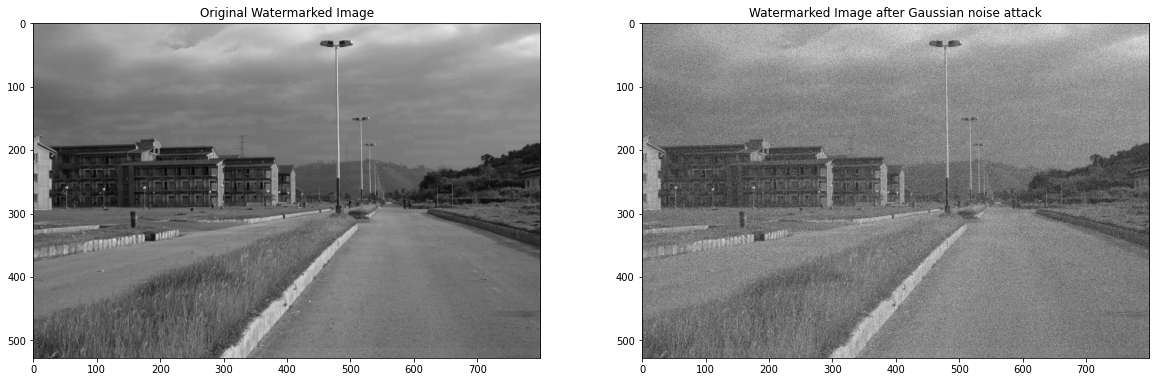

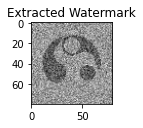

In [ ]:
gaussian_noise = np.random.normal(0,15,img_wm.shape) # mean = 0, SD = 30
img_wm_gaussian = img_wm + gaussian_noise

w_gaussian = detect(img,img_wm_gaussian,img1,logo1,alpha=30)

PSNR(img,img_wm_gaussian,img1)
nc(logo,w_gaussian)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Gaussian noise attack", fontsize='large')
ax2.imshow(img_wm_gaussian,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_gaussian,cmap="gray")

#### 2. Salt and Pepper Noise Attack

PSNR(dB): 25.54773655601523
nc: 0.9450295237452543


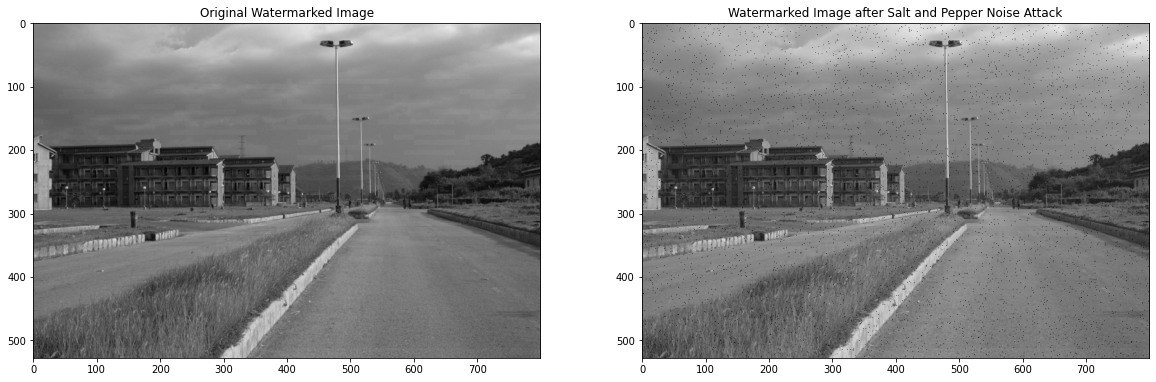

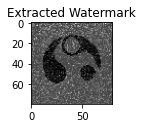

In [ ]:
s_vs_p = 0.5
amount = 0.01
img_wm_sp = deepcopy(img_wm)

num_salt = np.ceil(amount * img_wm.size * s_vs_p)

coords_salt = [np.random.randint(0, i - 1, int(num_salt)) for i in img_wm.shape]
img_wm_sp[coords_salt] = 1

num_pepper = np.ceil(amount* img_wm.size * (1 - s_vs_p))
coords_pepper = [np.random.randint(0, i - 1, int(num_pepper)) for i in img_wm.shape]
img_wm_sp[coords_pepper] = 0

w_sp = detect(img,img_wm_sp,img1,logo1,alpha=30)

PSNR(img,img_wm_sp,img1)
nc(logo,w_sp)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Salt and Pepper Noise Attack", fontsize='large')
ax2.imshow(img_wm_sp,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_sp,cmap="gray")

#### 3. Poisson Noise Attack

PSNR(dB): 13.83752616067704
nc: -0.8941873637038783


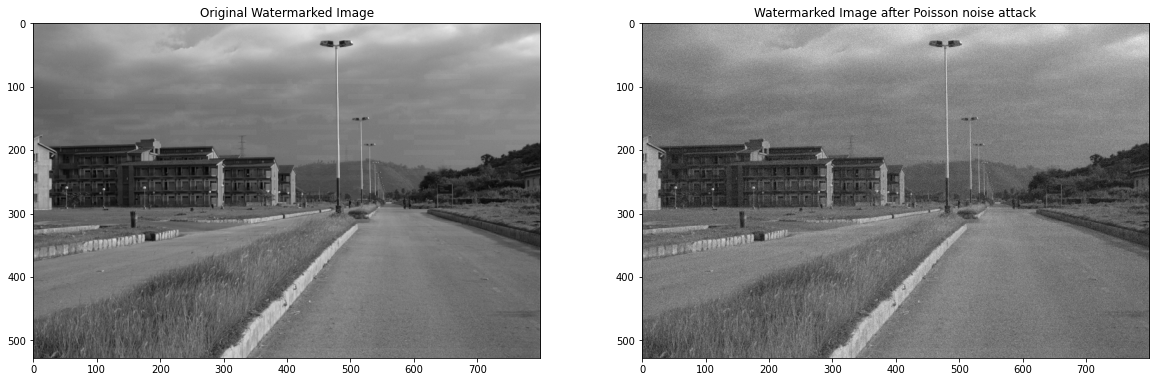

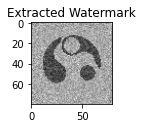

In [ ]:
poisson_noise_mask = np.random.poisson(lam=30, size=img_wm.shape)
img_wm_poisson = img_wm + noise_mask

w_poisson = detect(img,img_wm_poisson,img1,logo1,alpha=30)

PSNR(img,img_wm_poisson,img1)
nc(logo,w_poisson)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Poisson noise attack", fontsize='large')
ax2.imshow(img_wm_poisson,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_poisson,cmap="gray")


####. 4. Median Filter Attack 

PSNR(dB): 7.961285322127861
nc: 0.9270387925383584


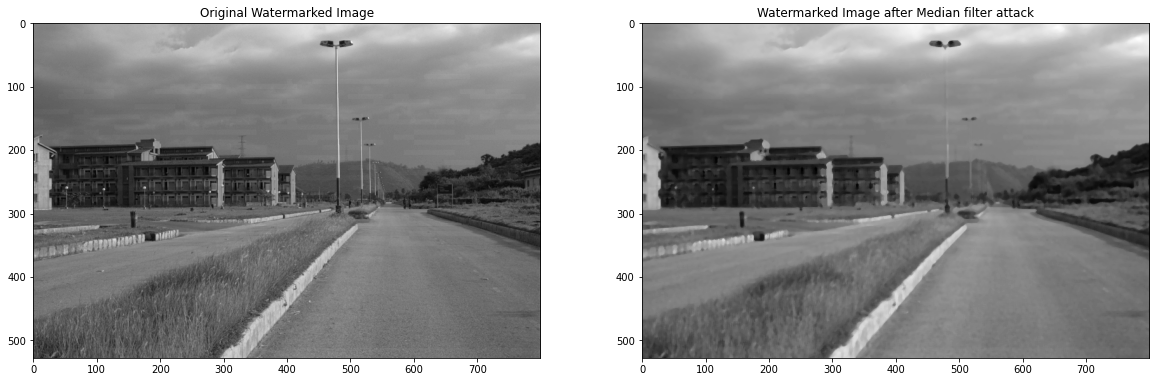

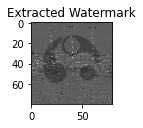

In [ ]:
img_wm_PIL = Image.fromarray(np.uint8(img_wm))
img_wm_PIL_median = img_wm_PIL.filter(ImageFilter.MedianFilter(size = 5))

img_wm_median = np.asarray(img_wm_PIL_median)

w_median = detect(img,img_wm_median,img1,logo1)

PSNR(img,img_wm_median,img1)
nc(logo,w_median)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Median filter attack", fontsize='large')
ax2.imshow(img_wm_median,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_median,cmap="gray")


#### 5. Gaussian Blur attack

PSNR(dB): 8.974584815784706
nc: 0.981041324582043


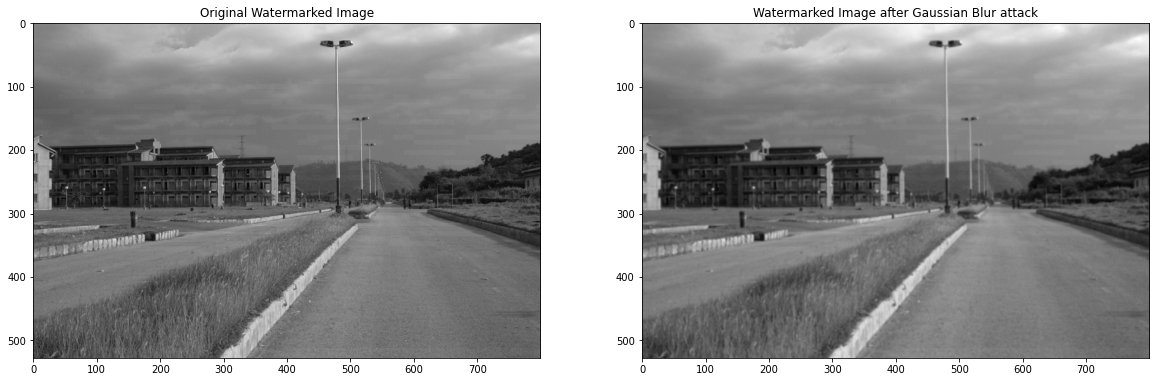

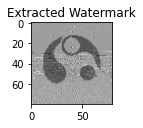

In [ ]:
img_wm_PIL = Image.fromarray(np.uint8(img_wm))
img_wm_PIL_gb = img_wm_PIL.filter(ImageFilter.GaussianBlur(radius=1))
img_wm_gb = np.asarray(img_wm_PIL_gb)

w_gb = detect(img,img_wm_gb,img1,logo1,alpha=30)

PSNR(img,img_wm_gb,img1)
nc(logo,w_gb)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Gaussian Blur attack", fontsize='large')
ax2.imshow(img_wm_gb,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_gb,cmap="gray")


#### 6. Mode Filter Attack

PSNR(dB): 15.286472487536873
nc: 0.9919362853731865


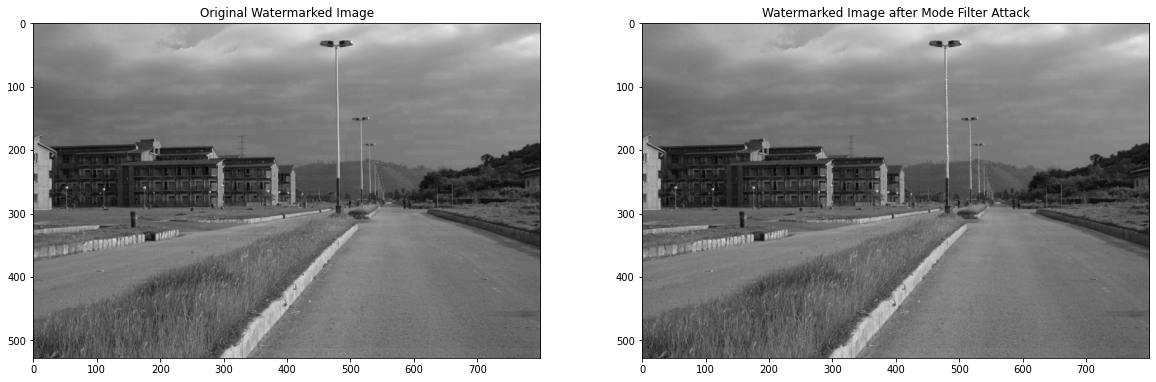

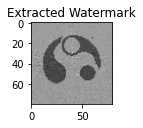

In [ ]:
img_wm_PIL = Image.fromarray(np.uint8(img_wm))
img_wm_PIL_mf = img_wm_PIL.filter(ImageFilter.ModeFilter(size=3))
img_wm_mf = np.asarray(img_wm_PIL_mf)

w_mf = detect(img,img_wm_mf,img1,logo1,alpha=30)

PSNR(img,img_wm_mf,img1)
nc(logo,w_mf)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Mode Filter Attack", fontsize='large')
ax2.imshow(img_wm_mf,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_mf,cmap="gray")

#### 7. Unsharp Masking Attack

PSNR(dB): 7.426793516270949
nc: 0.884058707040794


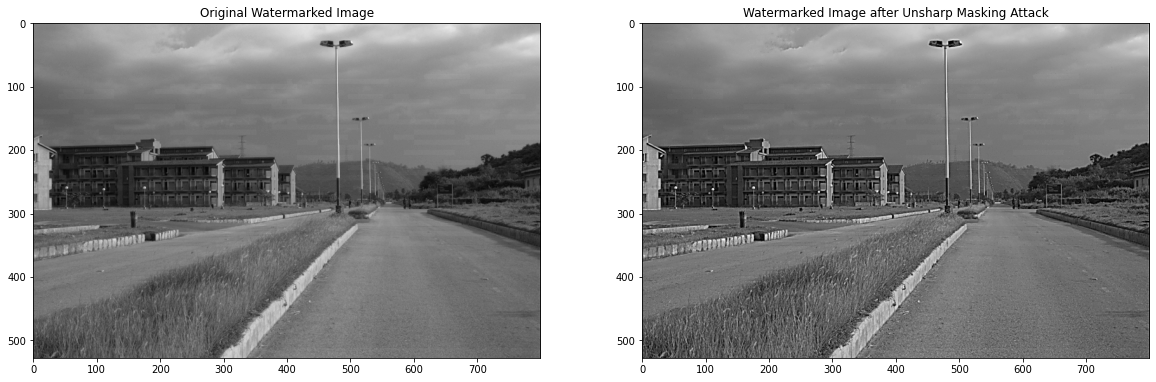

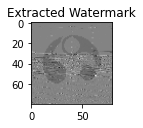

In [ ]:
img_wm_PIL = Image.fromarray(np.uint8(img_wm))
img_wm_PIL_um = img_wm_PIL.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
img_wm_um = np.asarray(img_wm_PIL_um)

w_um = detect(img,img_wm_um,img1,logo1,alpha=30)

PSNR(img,img_wm_um,img1)
nc(logo,w_um)

fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original Watermarked Image", fontsize='large')
ax1.imshow(img_wm,cmap = "gray")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Watermarked Image after Unsharp Masking Attack", fontsize='large')
ax2.imshow(img_wm_um,cmap = "gray")

plt.figure(2,figsize=(1.5,1.5))
plt.title("Extracted Watermark")
plt.imshow(w_um,cmap="gray")